<a href="https://colab.research.google.com/github/njweg/Machine-Learning-Exercises/blob/main/Sklearn_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following *Machine Learning with PyTorch and Scikit-Learn* by Sebastian Raschka et al.

---



In [ ]:
import sklearn
import numpy as np
import pandas as pd

In [ ]:
#get data
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,[2,3]]  #just using the petal information
y = iris.target

In [ ]:
#split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#standardize
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)  #find sample mean and std dev of training set (using fit method of StandardScaler class)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
#fit model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, solver="lbfgs", multi_class="multinomial")  #initialize a LogisticRegression object
lr.fit(X_train_std, y_train)

LogisticRegression(C=100.0, multi_class='multinomial')

----

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    #setup marker generator and color map
    markers = ('o', 's', '^', 'V', '<')
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])

    #plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f"Class {cl}",
                    edgecolor="black")


    #plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))  #see NumPy notebook
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)  #pass in data needs to have same structure as training set
    lab = lab.reshape(xx1.shape)  #now needs to have same shape as xx1 to pass into countourf (below)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    #highlight test examples
    if test_idx:  #passed in argument of plot_decision_regions()
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c="none", edgecolor="black", alpha=1.0, linewidth=1, marker='o', s=100,
                    label = "Test Set")

----

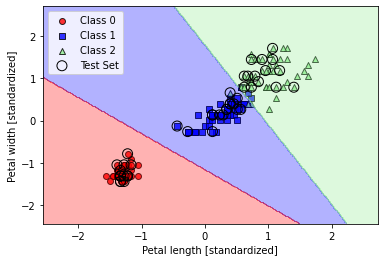

In [ ]:
#plot predictions and fit
X_combined = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel("Petal length [standardized]")
plt.ylabel("Petal width [standardized]")
plt.legend(loc="upper left")
plt.show()

----

In [ ]:
lr.score(X_test_std, y_test)

0.9777777777777777

In [ ]:
#predict probabilities for first 3 test examples
lr.predict_proba(X_test_std[0:3, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17]])

^ Each row is the output for each test example, e.g. the first row is the predicted class probabilities for the first test example

In [ ]:
#the sum of each row is 1
lr.predict_proba(X_test_std[0:3, :]).sum(axis=1)

array([1., 1., 1.])

In [ ]:
#the col. with the biggest number is the predicted class for that row
lr.predict_proba(X_test_std[0:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

^ So the predicted class for the first row is '2', for the next row is '0', and for the last '0'.

In [ ]:
#matches our manual prediction
lr.predict(X_test_std[0:3, :])

array([2, 0, 0])

**note:** if we want to just predict one flower using the `.predict` method we need to force that example to be a 2-diminsional array, as that's what the method expects as input. Use `.reshape(1,-1)`. --> the -1 makes python figure out the best answer; we don't really care what it is.

In [ ]:
lr.predict(X_test_std[0, :].reshape(1,-1))

array([2])

----

<function matplotlib.pyplot.show(*args, **kw)>

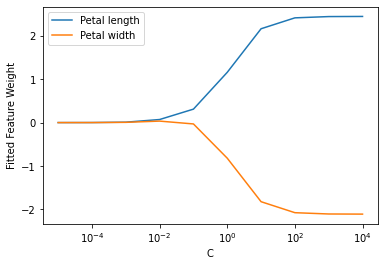

In [ ]:
weights, params = [], []
for c in np.arange(-5,5):
    lr = LogisticRegression(C=10.**c, multi_class="ovr")  #C=10^c for c in (-5,5)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])  #the weight coeff's for class 1 vs rest
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0], label="Petal length")
plt.plot(params, weights[:, 1], label="Petal width")
plt.ylabel("Fitted Feature Weight")
plt.xlabel("C")
plt.xscale("log")
plt.legend(loc="upper left")
plt.show

^ Abs value of both weights decrease with smaller C

----

When the output of our data is 0 or 1, we can try to fit the data with a sigmoid curve - i.e. we find "the sigmoid of best fit". Most of a sigmoid curve lies very close to 0 or 1, which is why it's fairly natural to fit binary data with a sigmoid curve. Since $\sigma (z)$ between 0 and 1, it's fairly natural to interpret the output as a probability (of $\mathbf{X}$ belonging to a given class)

**model:** find $\mathbf{W}$ such that $\mathrm{\sigma}(z) = \frac{1}{1 + \mathrm{e}^{-W \cdot X + b}}$ has as little error as possible.

**Loss function:** $L = \sum_{i = 1}^n {-y^{(i)} \, ln(\sigma(z^{(i)})) - (1-y^{(i)}) \, ln(1-\sigma(z^{(i)}))}$. This is the negative of maximum likelihood function.

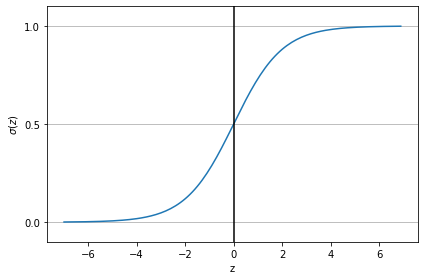

In [ ]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.ylim(-0.1, 1.1)
plt.xlabel("z")
plt.ylabel("$\sigma (z)$")
plt.axvline(0.0, color="k")  #vertical line at x=0.0
#ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

Notice: above we said that we're using the curve $\sigma (z)$ to fit the data. What if $\sigma (z)$ spits out a value other than 1 or 0? We will find the sigmoid of best fit by maximizing the maximum likelihood function (or minimizing LSE). Then, once we have the fitted $\mathbf{W}$, we make the actual predictions by thresholding $\sigma (z)$

So, we add one more component to the model - the threshold.
$\begin{align}
\hat{y} = \left\{
\begin{array}{cl}
1 & \sigma (z) \ge 0.5 \\
0 & otherwise
\end{array}
\right.
\end{align}$

Note: the thresholding is only applied when making predictions outside the training set; it has nothing to do with the fitting!